In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import geopandas as gpd
import shapely.geometry as sgeom
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import fiona
import os
import glob
import re
import joblib

from rasterstats import zonal_stats
from datetime import timedelta

os.chdir(r'E:\\Clasificacion')
current_work_directory = os.path.abspath(os.getcwd())
sns.set_style("darkgrid")

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing


In [3]:
import fiona
import rasterio.mask

def write_tiff(path_out, np_array, shapes, meta):
    
    with rio.open(folder_out + path_out, "w", **meta) as dest:
        dest.write(np_array, 1)

    if shapes is not None:
        with rio.open(folder_out + path_out) as src:
            out_image, out_transform = rasterio.mask.mask(src, shapes, crop=False)

        with rio.open(folder_out + path_out, "w", **meta) as dest:
            dest.write(out_image)

In [4]:
def obtenerEstadisticas(shpfile, raster_entrada, archivo_salida, tipo_salida='shp', nodata=-999):
    # Defino path del shapefile, lo abro con librería fiona y guardo en geometries los shapes correspondientes
    with fiona.open(shpfile) as records:
        geometries = [sgeom.shape(shp['geometry'])
                      for shp in records]
    
    p = re.compile(r'[A-Z]{2,5}([0-9]?)?')
    s = raster_entrada.split('\\')[-1] 
    prefix = p.search(s).group()
    print(prefix)
    
    # Calculo las estadísticas de valores mínimos, máximos y promedios
    zs = zonal_stats(geometries, raster_entrada, nodata=nodata, stats=['min', 'max', 'median', 'mean', 'std', 'count'], all_touched=True, prefix = prefix)
    # Abro el shapefile usando la librería GeoPandas
    tabla_shape = gpd.read_file(shpfile)
    # Creo un Dataframe con los valores estadísticos obtenidos
    stats_df = pd.DataFrame(zs)
    # Concateno las dos tablas
    tabla_shape = pd.concat([tabla_shape, stats_df], axis=1)
    # Escribo los resultados al disco
    if tipo_salida == 'shp':
        tabla_shape.to_file(archivo_salida)
    if tipo_salida == 'csv':
        tabla_shape.drop('geometry',axis=1).to_csv(archivo_salida)

    return

def listar_tiff(path, recursive = False):
    lista = []
    for file_name in glob.iglob(path+'**/*.tif', recursive = recursive):
        #print(file_name)
        lista.append(file_name)
    return lista

In [5]:
#Path donde estan las imagenes de los parámetros (Imágenes de Danilo corregistradas)
path_tif = r'E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\'


with rio.open(tif_path[:-4]+'_dB.tif', 'w', **metadatos) as outf:
    outf.write(img)

# Estadisticas

In [6]:
path_stats = r'Salida_estadisticas\\'
df_stats = gpd.read_file(path_stats + 'Estadisticas_par_SAR_CoreSiteROI_20200218_ASC.shp')

df_stats.tail()

,Name,Cultivo,EstadoFeno,Altura,ALPcount,ALPmax,ALPmean,ALPmedian,ALPmin,ALPstd,...,SPAMmedian,SPAMmin,SPAMstd,VSIcount,VSImax,VSImean,VSImedian,VSImin,VSIstd,geometry
98,C21,maiz,r6,250cm,304,64.046860,46.634547,46.883636,32.837990,5.214548,...,0.462534,0.198399,0.130209,304,0.432797,0.199739,0.196140,0.042979,0.066504,"POLYGON Z ((-62.63362 -32.88797 0.00000, -62.6..."
99,C22,soja,r5.5,120cm,378,68.302551,44.228154,44.505424,26.288139,6.437535,...,0.213629,0.098296,0.050947,378,0.681510,0.296246,0.286691,0.078578,0.102627,"POLYGON Z ((-62.60524 -32.89300 0.00000, -62.6..."
100,C23,soja,None,None,40,54.484264,42.512454,42.472466,31.833452,5.548285,...,0.199060,0.097495,0.056108,40,0.433075,0.164682,0.143678,0.068801,0.072886,"POLYGON Z ((-62.56834 -32.89927 0.00000, -62.5..."
101,C24,soja,r5.5,80cm,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"POLYGON Z ((-62.50352 -32.91079 0.00000, -62.4..."
102,C25,soja,r5.3,120cm,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"POLYGON Z ((-62.49677 -32.91203 0.00000, -62.4..."


In [7]:
lista_par_training = list(df_stats.columns.values)
lista_par_training = [x for x in lista_par_training if 'mean' in x]
lista_par_training

['ALPmean',
 'ANYmean',
 'BETmean',
 'BMImean',
 'CSImean',
 'DELmean',
 'ENTmean',
 'FHHVVmean',
 'FHVHHmean',
 'FVHVVmean',
 'GAMmean',
 'IRVmean',
 'HHVVmean',
 'HVHHmean',
 'VHVVmean',
 'PAUmean',
 'PHmean',
 'RHHmean',
 'RHVmean',
 'RVHmean',
 'RVVmean',
 'SPAMmean',
 'VSImean']

In [8]:
df_stats['Cultivo'].unique()

array(['maleza', 'soja', 'maiz', 'sorgo', 'alfalfa', 'rastrojo',
       'pastizal', 'laguna'], dtype=object)

In [9]:
mappings = {
    'maleza': 0,
    'soja': 1,
    'maiz': 2,
    'sorgo': 3,
    'alfalfa': 4,
    'rastrojo': 5,
    'pastizal': 6,
    'laguna': 7,

}

df_stats['y_map'] = df_stats['Cultivo'].map(mappings)
df_stats

,Name,Cultivo,EstadoFeno,Altura,ALPcount,ALPmax,ALPmean,ALPmedian,ALPmin,ALPstd,...,SPAMmin,SPAMstd,VSIcount,VSImax,VSImean,VSImedian,VSImin,VSIstd,geometry,y_map
0,A01,maleza,None,None,200,64.590515,41.339473,41.751698,24.813847,7.078404,...,0.073470,0.099307,200,0.660788,0.201625,0.191757,0.039811,0.083007,"POLYGON Z ((-62.70300 -32.60463 0.00000, -62.7...",0
1,A02,soja,R6.3,80cm,339,55.059761,38.609816,38.473522,18.698530,6.650530,...,0.063437,0.035484,339,0.531125,0.175189,0.163908,0.019828,0.076829,"POLYGON Z ((-62.73160 -32.59874 0.00000, -62.7...",1
2,A03,soja,r6.7,100cm,25,61.384796,44.230552,45.400127,31.723656,6.538654,...,0.156923,0.142324,25,0.701713,0.311897,0.322090,0.092425,0.126109,"POLYGON Z ((-62.74352 -32.60271 0.00000, -62.7...",1
3,A101,soja,r5,65cm,402,67.253189,42.597093,42.741722,16.037621,6.473652,...,0.071443,0.034849,402,0.505136,0.172197,0.159773,0.042976,0.073878,"POLYGON Z ((-62.81789 -32.58839 0.00000, -62.8...",1
4,A104,soja,r2,50cm,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"POLYGON Z ((-62.69134 -32.31298 0.00000, -62.6...",1
5,A105,maiz,r2,200cm,41,56.886257,44.402436,44.787537,27.958702,6.241626,...,0.142448,0.189684,41,0.326681,0.158128,0.141634,0.047600,0.069561,"POLYGON Z ((-62.68067 -32.43217 0.00000, -62.6...",2
6,A107,soja,r6.7,105cm,627,64.262604,43.062188,42.978279,26.559710,6.344760,...,0.048609,0.035555,627,0.592532,0.231636,0.221412,0.043929,0.089618,"POLYGON Z ((-62.70700 -32.55109 0.00000, -62.7...",1
7,A108,soja,r5,85cm,326,55.913750,38.986906,38.985550,22.424477,6.557130,...,0.057656,0.029808,326,0.391874,0.171428,0.163747,0.040742,0.065043,"POLYGON Z ((-62.70248 -32.56376 0.00000, -62.6...",1
8,A11,maiz,r5,None,225,58.954720,45.209905,45.076744,31.760303,5.107665,...,0.243072,0.169063,225,0.469011,0.245713,0.237523,0.090991,0.076566,"POLYGON Z ((-62.79129 -32.59267 0.00000, -62.7...",2
9,A13,soja,r6.9,90cm,714,65.177444,41.572681,41.268681,25.274281,5.365327,...,0.097685,0.075621,714,0.548238,0.188894,0.173347,0.048847,0.077541,"POLYGON Z ((-62.79092 -32.59663 0.00000, -62.7...",1


In [10]:
#df_stats_filtrado = df_stats[ df_stats['prof'] > 0]
df_stats = df_stats[ df_stats['ALPmean'] != 0]
df_stats.dropna(subset=['ALPmean'], inplace = True)
df_stats

,Name,Cultivo,EstadoFeno,Altura,ALPcount,ALPmax,ALPmean,ALPmedian,ALPmin,ALPstd,...,SPAMmin,SPAMstd,VSIcount,VSImax,VSImean,VSImedian,VSImin,VSIstd,geometry,y_map
0,A01,maleza,None,None,200,64.590515,41.339473,41.751698,24.813847,7.078404,...,0.073470,0.099307,200,0.660788,0.201625,0.191757,0.039811,0.083007,"POLYGON Z ((-62.70300 -32.60463 0.00000, -62.7...",0
1,A02,soja,R6.3,80cm,339,55.059761,38.609816,38.473522,18.698530,6.650530,...,0.063437,0.035484,339,0.531125,0.175189,0.163908,0.019828,0.076829,"POLYGON Z ((-62.73160 -32.59874 0.00000, -62.7...",1
2,A03,soja,r6.7,100cm,25,61.384796,44.230552,45.400127,31.723656,6.538654,...,0.156923,0.142324,25,0.701713,0.311897,0.322090,0.092425,0.126109,"POLYGON Z ((-62.74352 -32.60271 0.00000, -62.7...",1
3,A101,soja,r5,65cm,402,67.253189,42.597093,42.741722,16.037621,6.473652,...,0.071443,0.034849,402,0.505136,0.172197,0.159773,0.042976,0.073878,"POLYGON Z ((-62.81789 -32.58839 0.00000, -62.8...",1
5,A105,maiz,r2,200cm,41,56.886257,44.402436,44.787537,27.958702,6.241626,...,0.142448,0.189684,41,0.326681,0.158128,0.141634,0.047600,0.069561,"POLYGON Z ((-62.68067 -32.43217 0.00000, -62.6...",2
6,A107,soja,r6.7,105cm,627,64.262604,43.062188,42.978279,26.559710,6.344760,...,0.048609,0.035555,627,0.592532,0.231636,0.221412,0.043929,0.089618,"POLYGON Z ((-62.70700 -32.55109 0.00000, -62.7...",1
7,A108,soja,r5,85cm,326,55.913750,38.986906,38.985550,22.424477,6.557130,...,0.057656,0.029808,326,0.391874,0.171428,0.163747,0.040742,0.065043,"POLYGON Z ((-62.70248 -32.56376 0.00000, -62.6...",1
8,A11,maiz,r5,None,225,58.954720,45.209905,45.076744,31.760303,5.107665,...,0.243072,0.169063,225,0.469011,0.245713,0.237523,0.090991,0.076566,"POLYGON Z ((-62.79129 -32.59267 0.00000, -62.7...",2
9,A13,soja,r6.9,90cm,714,65.177444,41.572681,41.268681,25.274281,5.365327,...,0.097685,0.075621,714,0.548238,0.188894,0.173347,0.048847,0.077541,"POLYGON Z ((-62.79092 -32.59663 0.00000, -62.7...",1
10,A14,soja,r6.9,85cm,313,68.977127,46.836162,46.615040,25.246964,5.513044,...,0.137842,0.070917,313,0.777037,0.337841,0.330228,0.078295,0.094950,"POLYGON Z ((-62.81614 -32.58412 0.00000, -62.8...",1


In [ ]:
#shp_out = r'E:\Clasificacion\Salida_estadisticas\Estadisticas_ASC.shp'
#df_stats.to_file(shp_out)

In [11]:
df_stats['Cultivo'].unique()

array(['maleza', 'soja', 'maiz', 'sorgo', 'alfalfa'], dtype=object)

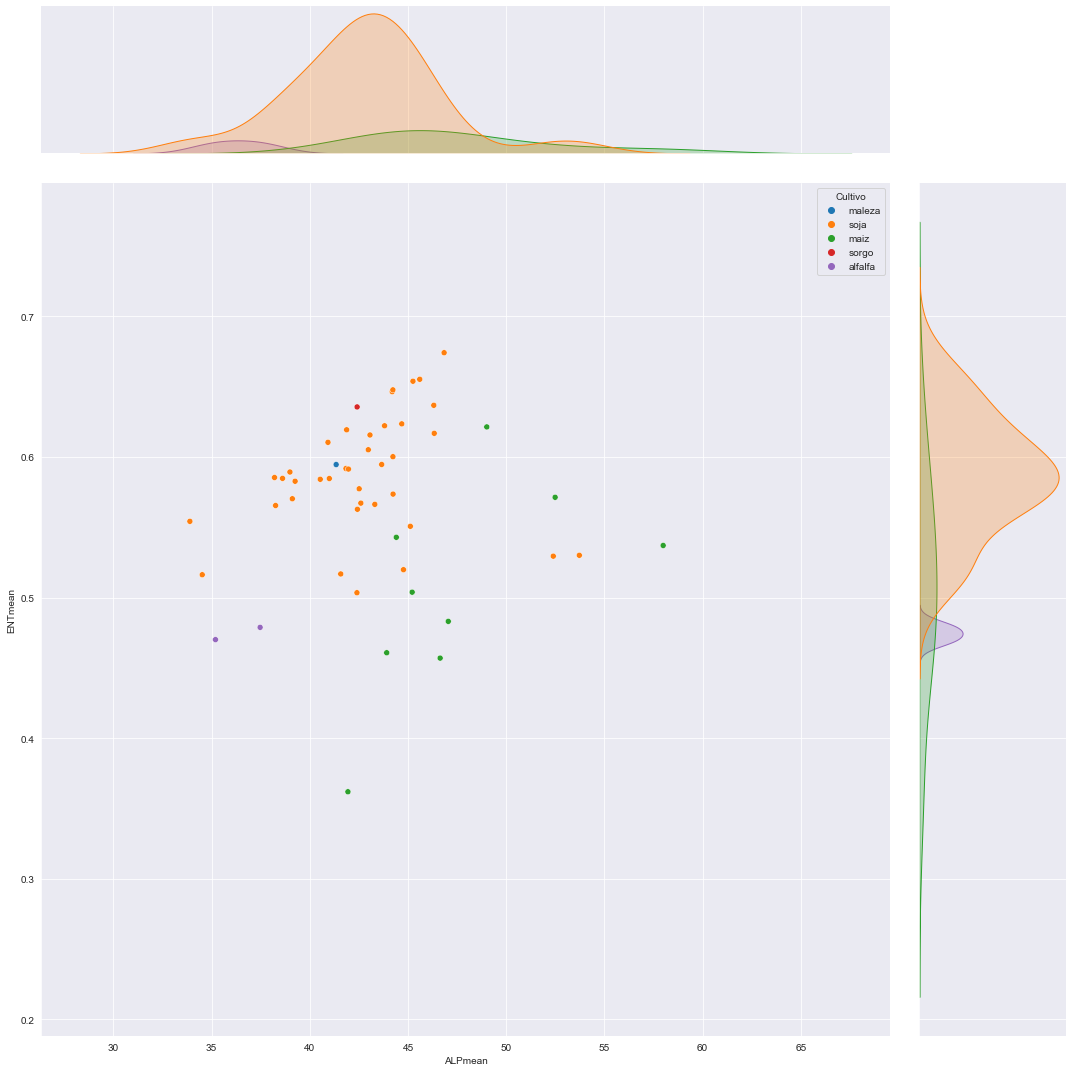

In [12]:
plot_Ha = sns.jointplot(data=df_stats, x= 'ALPmean', y='ENTmean', hue='Cultivo', height= 15)
plt.show(plot_Ha)

# Random Forest

In [13]:
def train_RF(df_a_usar, lista_par, string_modelo, optimizar = False):
    
    results_txt = os.path.join('Modelos', 'RF', 'Results_'+ string_modelo +'.txt')

    # División de los datos en train y test
    # ==============================================================================
    X_train, X_test, y_train, y_test = train_test_split(
                                        df_a_usar[lista_par],
                                        df_a_usar['y_map'],
                                        random_state = 123
                                    )
    
    
    # Creación del modelo
    # ==============================================================================
    modelo = RandomForestClassifier(
                n_estimators = 200,
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )

    print('Entrenando Modelo RandomForestlassifier', file=open(results_txt, "a"))
    print("-------------------------------------------", file=open(results_txt, "a"))
    print(modelo, file=open(results_txt, "a"))

    # Entrenamiento del modelo
    # ==============================================================================
    modelo.fit(X_train, y_train)
    
    
    # Plot de los datos de entrenamiento y error junto con correlación obtenidos
    # ==============================================================================
    df = pd.DataFrame()
    df['truth'] = y_train
    df['predict'] = modelo.predict(X_train)
    
    predicciones = modelo.predict(X_test)
    
    
    mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

    accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

    print("Matriz de confusión")
    print("-------------------")
    print(mat_confusion)
    print("")
    print(f"El accuracy de test es: {100 * accuracy} %")

    return modelo

# Modelos fusion 

In [14]:
lista_par_training = [x for x in lista_par_training if not 'PAUmean' in x]
lista_par_training

['ALPmean',
 'ANYmean',
 'BETmean',
 'BMImean',
 'CSImean',
 'DELmean',
 'ENTmean',
 'FHHVVmean',
 'FHVHHmean',
 'FVHVVmean',
 'GAMmean',
 'IRVmean',
 'HHVVmean',
 'HVHHmean',
 'VHVVmean',
 'PHmean',
 'RHHmean',
 'RHVmean',
 'RVHmean',
 'RVVmean',
 'SPAMmean',
 'VSImean']

In [15]:
modelo_todos_los_datos = train_RF(df_stats, lista_par_training, 'modelo_RF_basico_ASC', optimizar = False)

Matriz de confusión
-------------------
[[0 1 0 0 0]
 [0 8 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]

El accuracy de test es: 69.23076923076923 %


# Creacion Stack - aplicación modelo

# Aplicar modelo

In [23]:
folder_out = path_tif

In [24]:
folder_out

'E:\\Clasificacion\\PP\\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\\\'

In [26]:
lista_par_training

['ALPmean',
 'ANYmean',
 'BETmean',
 'BMImean',
 'CSImean',
 'DELmean',
 'ENTmean',
 'FHHVVmean',
 'FHVHHmean',
 'FVHVVmean',
 'GAMmean',
 'IRVmean',
 'HHVVmean',
 'HVHHmean',
 'VHVVmean',
 'PHmean',
 'RHHmean',
 'RHVmean',
 'RVHmean',
 'RVVmean',
 'SPAMmean',
 'VSImean']

In [25]:
lista_tiff_stack = listar_tiff(folder_out, recursive = True)
par_elegidos = lista_par_training
lista_tiff_stack

['E:\\Clasificacion\\PP\\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\CONAE_PRD_SAO1A_SAR_ALP_20200218_104201_bSMQP_v001\\CONAE_PRD_SAO1A_SAR_ALP_20200218_104201_bSMQP_v001.tif',
 'E:\\Clasificacion\\PP\\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\CONAE_PRD_SAO1A_SAR_ANY_20200218_104201_bSMQP_v001\\CONAE_PRD_SAO1A_SAR_ANY_20200218_104201_bSMQP_v001.tif',
 'E:\\Clasificacion\\PP\\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\CONAE_PRD_SAO1A_SAR_BET_20200218_104201_bSMQP_v001\\CONAE_PRD_SAO1A_SAR_BET_20200218_104201_bSMQP_v001.tif',
 'E:\\Clasificacion\\PP\\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\CONAE_PRD_SAO1A_SAR_BMI_20200218_104201_bSMQP_v001\\CONAE_PRD_SAO1A_SAR_BMI_20200218_104201_bSMQP_v001.tif',
 'E:\\Clasificacion\\PP\\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\CONAE_PRD_SAO1A_SAR_CSI_20200218_104201_bSMQP_v001\\CONAE_PRD_SAO1A_SAR_CSI_20200218_104201_bSMQP_v001.tif',
 'E:\\Clasificacion\\PP\\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\\CONAE_PRD_S

In [28]:
lista_par_training
lista_parametros = lista_par_training.copy()
for i in range(len(lista_parametros)):
    print(i)
    lista_parametros[i] = lista_parametros[i][:-4]
    print(lista_parametros[i])

0
ALP
1
ANY
2
BET
3
BMI
4
CSI
5
DEL
6
ENT
7
FHHVV
8
FHVHH
9
FVHVV
10
GAM
11
IRV
12
HHVV
13
HVHH
14
VHVV
15
PH
16
RHH
17
RHV
18
RVH
19
RVV
20
SPAM
21
VSI


In [29]:
lista_tiff_stack = [par for par in lista_tiff_stack if any(xs in par for xs in lista_parametros)]

print('Lista parametros training: \n')
print(*lista_tiff_stack, sep='\n \n')   
print('\n')

Lista parametros training: 

E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_ALP_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_ALP_20200218_104201_bSMQP_v001.tif
 
E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_ANY_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_ANY_20200218_104201_bSMQP_v001.tif
 
E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_BET_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_BET_20200218_104201_bSMQP_v001.tif
 
E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_BMI_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_BMI_20200218_104201_bSMQP_v001.tif
 
E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_CSI_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_CSI_20200218_104201_bSMQP_v001.tif
 
E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_DEL

In [30]:
for id, layer in enumerate(lista_tiff_stack, start=1):
    print(id, layer)

1 E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_ALP_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_ALP_20200218_104201_bSMQP_v001.tif
2 E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_ANY_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_ANY_20200218_104201_bSMQP_v001.tif
3 E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_BET_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_BET_20200218_104201_bSMQP_v001.tif
4 E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_BMI_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_BMI_20200218_104201_bSMQP_v001.tif
5 E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_CSI_20200218_104201_bSMQP_v001\CONAE_PRD_SAO1A_SAR_CSI_20200218_104201_bSMQP_v001.tif
6 E:\Clasificacion\PP\EOL1ASARSAO1A6937393_2020_02_18_orbit_ASCENDING\CONAE_PRD_SAO1A_SAR_DEL_20200218_104201_bSMQP_v001

In [32]:
folder_out = r'E:\Clasificacion\Stacks\\'
# Read metadata of first file
with rio.open(lista_tiff_stack[0]) as src0:
    meta = src0.meta

meta['count'] = len(lista_tiff_stack)
print(meta)  
output_stack = os.path.join(folder_out, 'Stack_RF_fusion_ASC.tif' )

print('Archivo stack: \n')
print(output_stack)
print('\n')
print('--------------------------------------------------------------------------')


# Read each layer and write it to stack
with rio.open(output_stack, 'w', **meta) as dst:
    for id, layer in enumerate(lista_tiff_stack, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2773, 'height': 3676, 'count': 22, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00027767777056028555, 0.0, -63.040000915527344,
       0.0, -0.00027770186663971116, -32.25166702270508)}
Archivo stack: 

E:\Clasificacion\Stacks\\Stack_RF_fusion_ASC.tif


--------------------------------------------------------------------------


In [ ]:
#path_modelos = r'E:\Dragado\Batimetria\Modelos\RF\Modelo_modelo_fusion.pkl'
#modelo_fusion = joblib.load(path_modelos)

In [33]:
with rio.open(output_stack) as src:
    metadatos = src.meta.copy()
    stack_v = src.read()
    img = src.read(1)

stack_v = np.moveaxis(stack_v, 0, -1)

# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (stack_v.shape[0] * stack_v.shape[1], stack_v.shape[2])

img_as_array = stack_v[:, :, :].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=stack_v.shape,
                                        n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)        


# Now predict for each pixel
class_prediction_v = modelo_todos_los_datos.predict(img_as_array)

# Reshape our classification map

class_prediction_v = class_prediction_v.reshape(stack_v[:, :, 0].shape)


Reshaped from (3676, 2773, 22) to (10193548, 22)


In [34]:
nodatavalue = -999
img1 = np.nan_to_num(img, nan = nodatavalue)        

class_prediction_v[np.where(img1 == nodatavalue )] = nodatavalue

metadatos['count'] = 1
metadatos['nodata'] = nodatavalue


with rio.open(folder_out + 'Clasificacion_RF_ASC.tif', 'w', **metadatos) as outf:
    outf.write(class_prediction_v, 1)


In [ ]:
class_prediction_v[np.argwhere(np.isnan(img))] = -999